# Hodina 8: AI ve hrách

## Obsah hodiny
- Historie AI ve hrách
- Typy herní AI
- Praktická implementace s neurnovými sítěmi
- Reinforcement learning ve hrách
- Vytvoření vlastní herní AI

---

## Instalace potřebných knihoven

# Hodina 8 — AI ve hrách (ELI10)

Hry jsou skvělý způsob, jak pochopit AI. Dnes uděláme jednoduchého hráče pro Tic-Tac-Toe (Piškvorky) pomocí algoritmu minimax.

Cíl: pochopit, jak počítač "přemýšlí" o tazích a proč někdy hledá "nejlepší" tah.

In [1]:
# Instalace knihoven pro herní AI
!pip install tensorflow torch pygame gym stable-baselines3 numpy matplotlib -q
!pip install gradio transformers -q

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import time
from IPython.display import clear_output
import gradio as gr

print("✅ Knihovny nainstalovány!")
print(f"PyTorch verze: {torch.__version__}")

/Users/martinsvanda/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Knihovny nainstalovány!
PyTorch verze: 2.8.0


## 1. Historie AI ve hrách

### Milníky herní AI:
- **1950** - Šachové programy (Claude Shannon)
- **1978** - Space Invaders (první adaptivní obtížnost)
- **1980** - Pac-Man (duchové s různými strategiemi)
- **1997** - Deep Blue poráží Kasparova
- **2016** - AlphaGo poráží mistra Go
- **2019** - OpenAI Five v Dota 2
- **2022** - AI v moderních hrách (NPCs, procedurální generování)

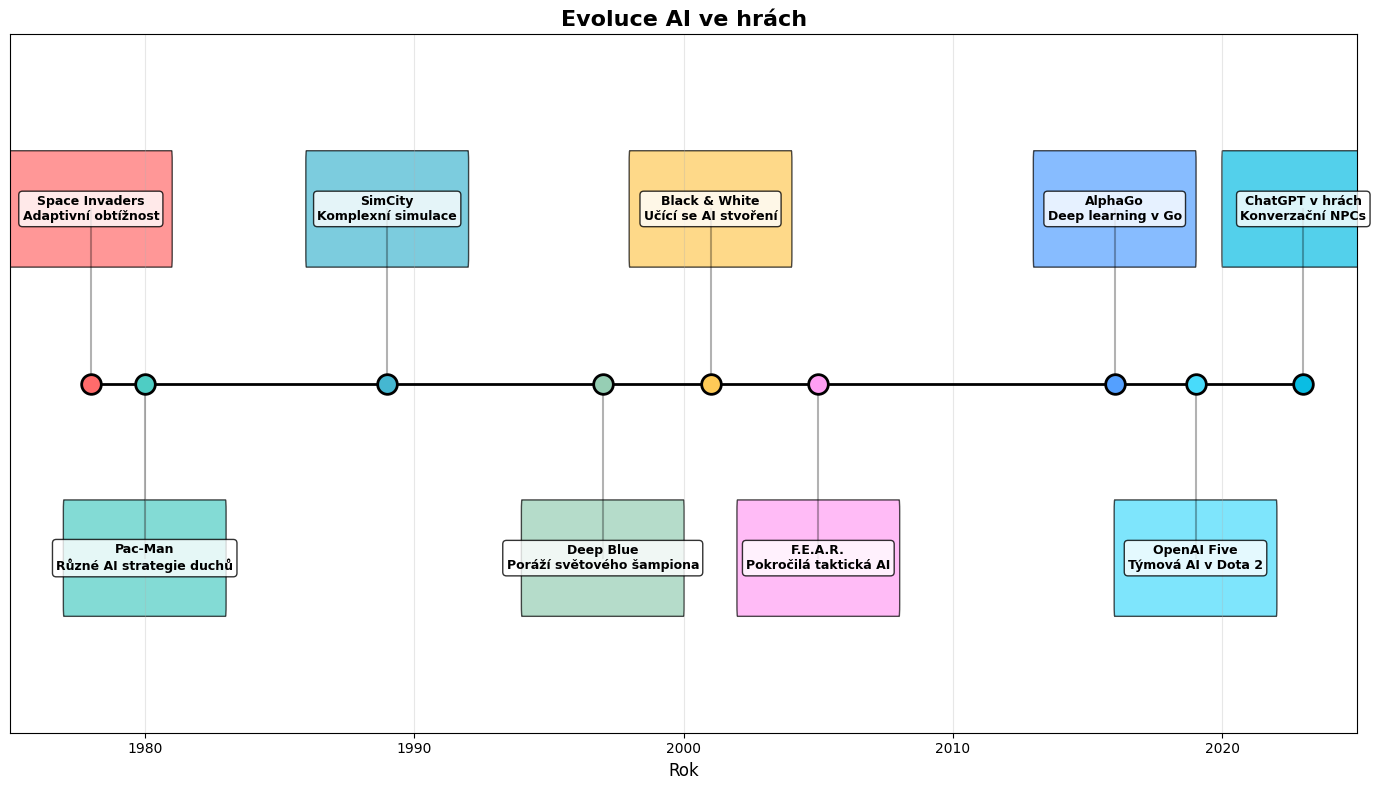

🎮 Od jednoduchých pravidel k deep learningu!


In [2]:
# Vizualizace evoluce herní AI
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch

# Data o hrách a jejich AI
games_timeline = [
    (1978, "Space Invaders", "Adaptivní obtížnost", "#FF6B6B"),
    (1980, "Pac-Man", "Různé AI strategie duchů", "#4ECDC4"),
    (1989, "SimCity", "Komplexní simulace", "#45B7D1"),
    (1997, "Deep Blue", "Poráží světového šampiona", "#96CEB4"),
    (2001, "Black & White", "Učící se AI stvoření", "#FECA57"),
    (2005, "F.E.A.R.", "Pokročilá taktická AI", "#FF9FF3"),
    (2016, "AlphaGo", "Deep learning v Go", "#54A0FF"),
    (2019, "OpenAI Five", "Týmová AI v Dota 2", "#48DBFB"),
    (2023, "ChatGPT v hrách", "Konverzační NPCs", "#0ABDE3")
]

fig, ax = plt.subplots(figsize=(14, 8))

# Vykreslení časové osy
years = [g[0] for g in games_timeline]
ax.plot(years, [0]*len(years), 'k-', linewidth=2)

# Přidání bodů a popisků
for i, (year, game, description, color) in enumerate(games_timeline):
    y_offset = 0.3 if i % 2 == 0 else -0.3
    
    # Bod na časové ose
    ax.scatter(year, 0, s=200, c=color, zorder=3, edgecolors='black', linewidth=2)
    
    # Spojnice
    ax.plot([year, year], [0, y_offset], 'k-', alpha=0.3)
    
    # Textový box
    bbox = FancyBboxPatch((year-3, y_offset-0.08), 6, 0.16, 
                         boxstyle="round,pad=0.02", 
                         facecolor=color, alpha=0.7, edgecolor='black')
    ax.add_patch(bbox)
    
    # Text
    ax.text(year, y_offset, f"{game}\n{description}", 
            ha='center', va='center', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

ax.set_xlim(1975, 2025)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel('Rok', fontsize=12)
ax.set_title('Evoluce AI ve hrách', fontsize=16, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)
ax.set_yticks([])

plt.tight_layout()
plt.show()

print("🎮 Od jednoduchých pravidel k deep learningu!")

## 2. Typy herní AI

### Základní techniky:
1. **Finite State Machines (FSM)** - stavy a přechody
2. **Behavior Trees** - hierarchické rozhodování  
3. **Pathfinding** - A*, Dijkstra
4. **Decision Trees** - if-then pravidla
5. **Neural Networks** - učení ze zkušeností
6. **Reinforcement Learning** - učení pomocí odměn

/var/folders/gl/wfvc1p910_l9lfrd_qzyhrb40000gn/T/ipykernel_70653/476270371.py:82: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  player_circle = Circle((player_x, player_y), 0.4, color='yellow', edgecolor='black', linewidth=2)
/var/folders/gl/wfvc1p910_l9lfrd_qzyhrb40000gn/T/ipykernel_70653/476270371.py:97: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ghost_circle = Circle((ghost.x, ghost.y), 0.4, color=ghost.color, edgecolor='black', linewidth=2)
/var/folders/gl/wfvc1p910_l9lfrd_qzyhrb40000gn/T/ipykernel_70653/476270371.py:124: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gl/wfvc1p910_l9lfrd_qzyhrb40000gn/T/ipykernel_70653/476270371.py:124: UserWarning: Glyph 129655 (\N{PINK HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/gl/wfvc1p910_l9lfrd_qzyhrb40000gn/T/ipykernel_70653/476270371.py:

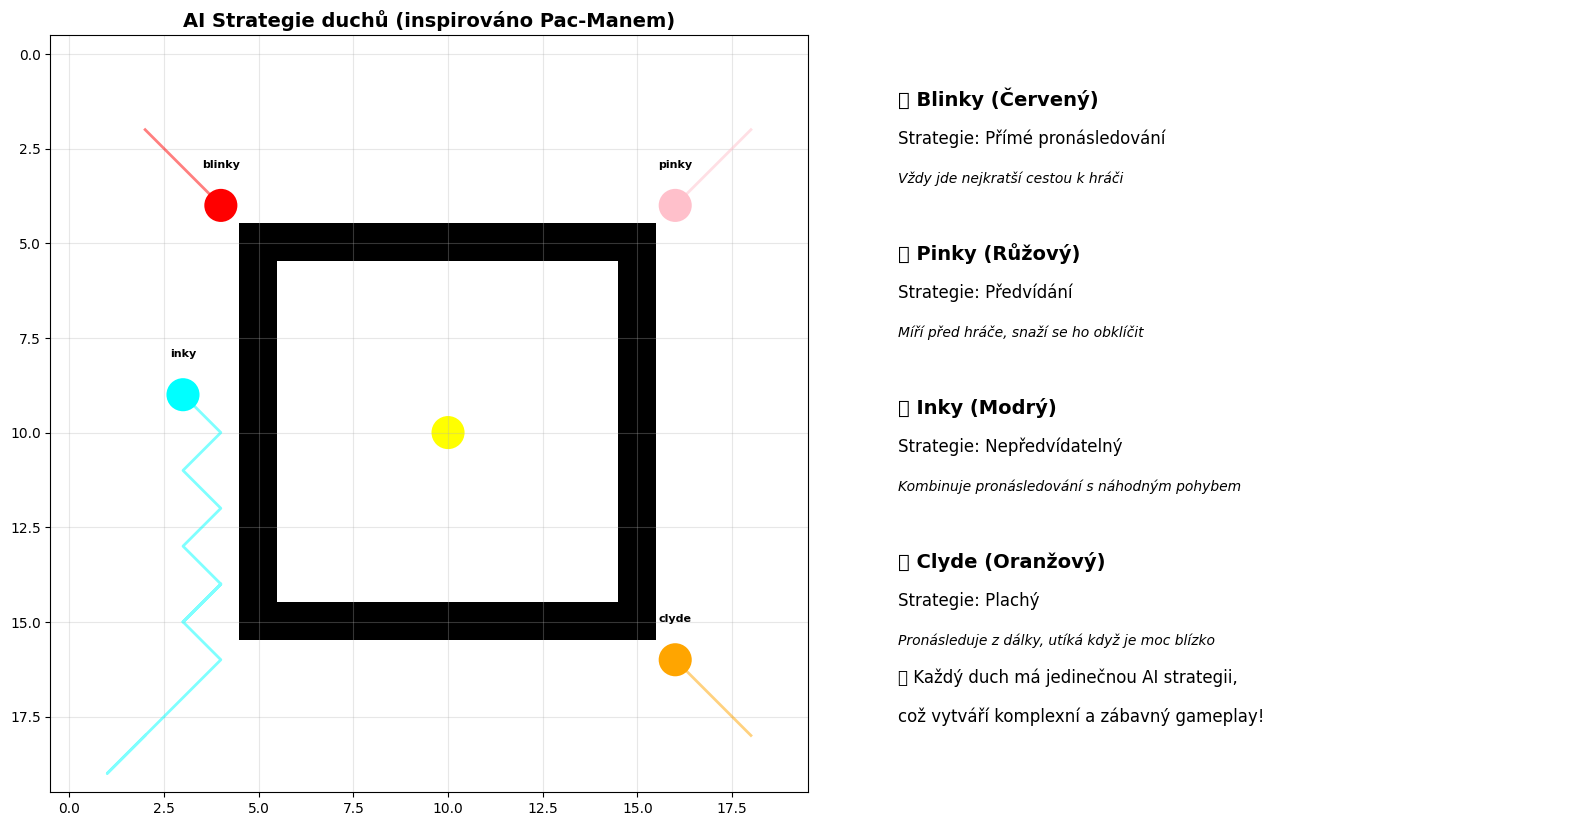

In [3]:
# Implementace různých AI strategií (inspirováno Pac-Manem)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import matplotlib.animation as animation

class Ghost:
    def __init__(self, x, y, color, strategy):
        self.x = x
        self.y = y
        self.color = color
        self.strategy = strategy
        self.path = [(x, y)]
        
    def move(self, player_x, player_y, maze):
        """Pohyb podle strategie"""
        if self.strategy == "blinky":  # Přímé pronásledování
            dx = np.sign(player_x - self.x)
            dy = np.sign(player_y - self.y)
        
        elif self.strategy == "pinky":  # Předvídání - míří před hráče
            future_x = player_x + np.random.randint(-2, 3)
            future_y = player_y + np.random.randint(-2, 3)
            dx = np.sign(future_x - self.x)
            dy = np.sign(future_y - self.y)
        
        elif self.strategy == "inky":  # Nepředvídatelný
            if np.random.random() < 0.7:  # 70% šance pronásledovat
                dx = np.sign(player_x - self.x)
                dy = np.sign(player_y - self.y)
            else:  # 30% náhodný pohyb
                dx = np.random.choice([-1, 0, 1])
                dy = np.random.choice([-1, 0, 1])
        
        elif self.strategy == "clyde":  # Plachý - drží se dál
            distance = np.sqrt((player_x - self.x)**2 + (player_y - self.y)**2)
            if distance < 5:  # Příliš blízko - utíká
                dx = -np.sign(player_x - self.x)
                dy = -np.sign(player_y - self.y)
            else:  # Pronásleduje z dálky
                dx = np.sign(player_x - self.x)
                dy = np.sign(player_y - self.y)
        
        # Kontrola kolizí a pohyb
        new_x = np.clip(self.x + dx, 0, maze.shape[1]-1)
        new_y = np.clip(self.y + dy, 0, maze.shape[0]-1)
        
        if maze[int(new_y), int(new_x)] == 0:  # Volné pole
            self.x = new_x
            self.y = new_y
            self.path.append((self.x, self.y))

# Vytvoření jednoduché mapy
maze_size = 20
maze = np.zeros((maze_size, maze_size))

# Přidání zdí
maze[5:15, 5] = 1
maze[5:15, 15] = 1
maze[5, 5:16] = 1
maze[15, 5:16] = 1

# Inicializace duchů s různými strategiemi
ghosts = [
    Ghost(2, 2, 'red', 'blinky'),     # Přímý pronásledovatel
    Ghost(18, 2, 'pink', 'pinky'),    # Předvídač
    Ghost(2, 18, 'cyan', 'inky'),     # Nepředvídatelný
    Ghost(18, 18, 'orange', 'clyde')  # Plachý
]

# Pozice hráče
player_x, player_y = 10, 10

# Vizualizace
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Levý graf - mapa s duchy
ax1.imshow(maze, cmap='binary')
ax1.set_title('AI Strategie duchů (inspirováno Pac-Manem)', fontsize=14, fontweight='bold')

# Hráč
player_circle = Circle((player_x, player_y), 0.4, color='yellow', edgecolor='black', linewidth=2)
ax1.add_patch(player_circle)

# Simulace 30 kroků
for step in range(30):
    for ghost in ghosts:
        ghost.move(player_x, player_y, maze)

# Vykreslení cest duchů
for ghost in ghosts:
    path_x = [p[0] for p in ghost.path]
    path_y = [p[1] for p in ghost.path]
    ax1.plot(path_x, path_y, color=ghost.color, alpha=0.5, linewidth=2)
    
    # Konečná pozice ducha
    ghost_circle = Circle((ghost.x, ghost.y), 0.4, color=ghost.color, edgecolor='black', linewidth=2)
    ax1.add_patch(ghost_circle)
    ax1.text(ghost.x, ghost.y-1, ghost.strategy, ha='center', fontsize=8, fontweight='bold')

ax1.set_xlim(-0.5, maze_size-0.5)
ax1.set_ylim(maze_size-0.5, -0.5)
ax1.grid(True, alpha=0.3)

# Pravý graf - popis strategií
ax2.axis('off')
strategies_text = [
    ("🔴 Blinky (Červený)", "Přímé pronásledování", "Vždy jde nejkratší cestou k hráči"),
    ("🩷 Pinky (Růžový)", "Předvídání", "Míří před hráče, snaží se ho obklíčit"),
    ("🔵 Inky (Modrý)", "Nepředvídatelný", "Kombinuje pronásledování s náhodným pohybem"),
    ("🟠 Clyde (Oranžový)", "Plachý", "Pronásleduje z dálky, utíká když je moc blízko")
]

y_pos = 0.9
for name, strategy, description in strategies_text:
    ax2.text(0.1, y_pos, name, fontsize=14, fontweight='bold')
    ax2.text(0.1, y_pos-0.05, f"Strategie: {strategy}", fontsize=12)
    ax2.text(0.1, y_pos-0.1, description, fontsize=10, style='italic')
    y_pos -= 0.2

ax2.text(0.1, 0.15, "💡 Každý duch má jedinečnou AI strategii,", fontsize=12)
ax2.text(0.1, 0.1, "což vytváří komplexní a zábavný gameplay!", fontsize=12)

plt.tight_layout()
plt.show()

## 3. Neuronová síť hrající hru

### Deep Q-Network (DQN)
Implementujeme AI, která se naučí hrát jednoduchou hru pomocí reinforcement learningu.

In [4]:
# Jednoduchá hra Snake s DQN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

class SnakeGame:
    def __init__(self, width=10, height=10):
        self.width = width
        self.height = height
        self.reset()
        
    def reset(self):
        """Reset hry"""
        self.snake = [(self.width//2, self.height//2)]
        self.direction = (0, 1)  # Doprava
        self.food = self._place_food()
        self.score = 0
        self.steps = 0
        self.max_steps = 100
        return self._get_state()
    
    def _place_food(self):
        """Umístění jídla"""
        while True:
            food = (random.randint(0, self.width-1), 
                   random.randint(0, self.height-1))
            if food not in self.snake:
                return food
    
    def _get_state(self):
        """Získání stavu hry pro neuronovou síť"""
        head = self.snake[0]
        
        # 8 směrů kolem hlavy (nebezpečí)
        danger = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                next_pos = (head[0] + dx, head[1] + dy)
                is_danger = (next_pos in self.snake or 
                           next_pos[0] < 0 or next_pos[0] >= self.width or
                           next_pos[1] < 0 or next_pos[1] >= self.height)
                danger.append(float(is_danger))
        
        # Směr k jídlu
        food_dx = self.food[0] - head[0]
        food_dy = self.food[1] - head[1]
        
        # Aktuální směr
        dir_up = float(self.direction == (0, -1))
        dir_down = float(self.direction == (0, 1))
        dir_left = float(self.direction == (-1, 0))
        dir_right = float(self.direction == (1, 0))
        
        state = danger + [food_dx/self.width, food_dy/self.height, 
                         dir_up, dir_down, dir_left, dir_right]
        
        return np.array(state, dtype=np.float32)
    
    def step(self, action):
        """Provedení akce"""
        self.steps += 1
        
        # Změna směru (0=rovně, 1=doleva, 2=doprava)
        if action == 1:  # Doleva
            self.direction = (-self.direction[1], self.direction[0])
        elif action == 2:  # Doprava
            self.direction = (self.direction[1], -self.direction[0])
        
        # Pohyb
        head = self.snake[0]
        new_head = (head[0] + self.direction[0], head[1] + self.direction[1])
        
        # Kontrola kolize
        if (new_head in self.snake or 
            new_head[0] < 0 or new_head[0] >= self.width or
            new_head[1] < 0 or new_head[1] >= self.height):
            return self._get_state(), -10, True  # Game over
        
        self.snake.insert(0, new_head)
        
        # Kontrola jídla
        reward = 0
        if new_head == self.food:
            self.score += 1
            reward = 10
            self.food = self._place_food()
            self.steps = 0  # Reset kroků po jídle
        else:
            self.snake.pop()  # Odstranění ocasu
            # Malá odměna za přiblížení k jídlu
            old_dist = abs(head[0] - self.food[0]) + abs(head[1] - self.food[1])
            new_dist = abs(new_head[0] - self.food[0]) + abs(new_head[1] - self.food[1])
            if new_dist < old_dist:
                reward = 1
        
        # Kontrola max kroků
        done = self.steps >= self.max_steps
        
        return self._get_state(), reward, done
    
    def render(self, ax):
        """Vykreslení hry"""
        ax.clear()
        
        # Mřížka
        ax.set_xlim(-0.5, self.width-0.5)
        ax.set_ylim(-0.5, self.height-0.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        
        # Had
        for i, (x, y) in enumerate(self.snake):
            color = 'darkgreen' if i == 0 else 'green'
            ax.add_patch(plt.Rectangle((x-0.4, y-0.4), 0.8, 0.8, 
                                      facecolor=color, edgecolor='black'))
        
        # Jídlo
        ax.add_patch(plt.Circle(self.food, 0.3, color='red'))
        
        ax.set_title(f'Skóre: {self.score} | Kroky: {self.steps}')
        ax.invert_yaxis()

# DQN neuronová síť
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Trénování DQN
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = lr
        
        # Neuronová síť
        self.q_network = DQN(state_size, 128, action_size)
        self.target_network = DQN(state_size, 128, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        self.update_target_network()
        
    def update_target_network(self):
        """Aktualizace target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
        
    def remember(self, state, action, reward, next_state, done):
        """Uložení do paměti"""
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        """Výběr akce"""
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_network(state_tensor)
        return np.argmax(q_values.detach().numpy())
    
    def replay(self, batch_size=32):
        """Trénování z paměti"""
        if len(self.memory) < batch_size:
            return
            
        batch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.FloatTensor([e[4] for e in batch])
        
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (0.95 * next_q_values * (1 - dones))
        
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Trénování AI
print("🐍 TRÉNOVÁNÍ AI PRO HRU SNAKE\n")

game = SnakeGame()
agent = DQNAgent(state_size=14, action_size=3)

episodes = 100
scores = []
avg_scores = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

print("🧠 Trénuji neuronovou síť...")
for episode in range(episodes):
    state = game.reset()
    total_reward = 0
    
    while True:
        action = agent.act(state)
        next_state, reward, done = game.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        if done:
            break
            
        agent.replay()
    
    scores.append(game.score)
    avg_score = np.mean(scores[-10:])
    avg_scores.append(avg_score)
    
    if episode % 10 == 0:
        agent.update_target_network()
        clear_output(wait=True)
        
        # Vizualizace pokroku
        ax1.clear()
        ax1.plot(scores, alpha=0.5, label='Skóre')
        ax1.plot(avg_scores, linewidth=2, label='Průměr (10 her)')
        ax1.set_xlabel('Epizoda')
        ax1.set_ylabel('Skóre')
        ax1.set_title('Pokrok učení AI')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Ukázka hry
        game.render(ax2)
        
        plt.suptitle(f'Epizoda {episode} | Epsilon: {agent.epsilon:.3f} | Průměrné skóre: {avg_score:.2f}', 
                    fontsize=14)
        plt.tight_layout()
        plt.show()
        
        print(f"Epizoda {episode}: Skóre = {game.score}, Průměr = {avg_score:.2f}")

print("\n✅ Trénování dokončeno!")
print(f"Nejlepší skóre: {max(scores)}")
print(f"Průměrné skóre posledních 10 her: {avg_scores[-1]:.2f}")

<Figure size 640x480 with 0 Axes>

Epizoda 90: Skóre = 23, Průměr = 16.10

✅ Trénování dokončeno!
Nejlepší skóre: 26
Průměrné skóre posledních 10 her: 10.50

✅ Trénování dokončeno!
Nejlepší skóre: 26
Průměrné skóre posledních 10 her: 10.50


## 4. Minimax algoritmus - Piškvorky

In [5]:
# Interaktivní piškvorky s Minimax AI
import gradio as gr
import numpy as np

class TicTacToeAI:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.player = 1  # Hráč
        self.ai = -1     # AI
        
    def reset(self):
        """Reset hry"""
        self.board = np.zeros((3, 3), dtype=int)
        return self.board
    
    def check_winner(self, board):
        """Kontrola výherce"""
        # Řádky
        for row in board:
            if row.sum() == 3: return 1
            if row.sum() == -3: return -1
        
        # Sloupce
        for col in board.T:
            if col.sum() == 3: return 1
            if col.sum() == -3: return -1
        
        # Diagonály
        diag1 = board[0,0] + board[1,1] + board[2,2]
        diag2 = board[0,2] + board[1,1] + board[2,0]
        
        if diag1 == 3 or diag2 == 3: return 1
        if diag1 == -3 or diag2 == -3: return -1
        
        # Remíza
        if np.all(board != 0): return 0
        
        # Hra pokračuje
        return None
    
    def minimax(self, board, depth, is_maximizing):
        """Minimax algoritmus"""
        winner = self.check_winner(board)
        
        # Terminální stavy
        if winner == self.ai: return 10 - depth
        if winner == self.player: return depth - 10
        if winner == 0: return 0
        
        if is_maximizing:
            best_score = -float('inf')
            for i in range(3):
                for j in range(3):
                    if board[i,j] == 0:
                        board[i,j] = self.ai
                        score = self.minimax(board, depth + 1, False)
                        board[i,j] = 0
                        best_score = max(score, best_score)
            return best_score
        else:
            best_score = float('inf')
            for i in range(3):
                for j in range(3):
                    if board[i,j] == 0:
                        board[i,j] = self.player
                        score = self.minimax(board, depth + 1, True)
                        board[i,j] = 0
                        best_score = min(score, best_score)
            return best_score
    
    def ai_move(self):
        """Nejlepší tah AI"""
        best_score = -float('inf')
        best_move = None
        
        for i in range(3):
            for j in range(3):
                if self.board[i,j] == 0:
                    self.board[i,j] = self.ai
                    score = self.minimax(self.board.copy(), 0, False)
                    self.board[i,j] = 0
                    
                    if score > best_score:
                        best_score = score
                        best_move = (i, j)
        
        if best_move:
            self.board[best_move[0], best_move[1]] = self.ai
        
        return self.board
    
    def player_move(self, row, col):
        """Tah hráče"""
        if self.board[row, col] == 0:
            self.board[row, col] = self.player
            return True
        return False
    
    def get_board_display(self):
        """Zobrazení herní desky"""
        symbols = {0: '⬜', 1: '❌', -1: '⭕'}
        display = ""
        for row in self.board:
            display += " ".join([symbols[cell] for cell in row]) + "\n"
        return display

# Vytvoření hry
game = TicTacToeAI()

# Test Minimax AI
print("🎮 PIŠKVORKY S MINIMAX AI\n")
print("AI používá Minimax algoritmus - je neporazitelná!\n")

# Simulace hry
print("Ukázková hra:")
game.reset()

# Několik tahů
moves = [(1, 1), (0, 0), (2, 2)]
for i, (row, col) in enumerate(moves):
    print(f"\nTah {i+1} - Hráč (❌) hraje na pozici ({row}, {col})")
    game.player_move(row, col)
    print(game.get_board_display())
    
    winner = game.check_winner(game.board)
    if winner is not None:
        break
    
    print("AI (⭕) přemýšlí...")
    game.ai_move()
    print(game.get_board_display())
    
    winner = game.check_winner(game.board)
    if winner is not None:
        break

# Gradio interface pro interaktivní hru
def play_game(btn_id):
    global game
    
    if btn_id == "reset":
        game.reset()
        return game.get_board_display(), "Nová hra! Jste na tahu (❌)"
    
    # Parsování pozice z btn_id
    try:
        row, col = map(int, btn_id.split('_'))
    except:
        return game.get_board_display(), "Neplatný tah"
    
    # Tah hráče
    if not game.player_move(row, col):
        return game.get_board_display(), "Toto pole je již obsazené!"
    
    # Kontrola výhry
    winner = game.check_winner(game.board)
    if winner == 1:
        return game.get_board_display(), "🎉 Vyhráli jste! (To by se nemělo stát 😅)"
    elif winner == 0:
        return game.get_board_display(), "🤝 Remíza!"
    
    # Tah AI
    game.ai_move()
    
    # Kontrola výhry po tahu AI
    winner = game.check_winner(game.board)
    if winner == -1:
        return game.get_board_display(), "🤖 AI vyhrála!"
    elif winner == 0:
        return game.get_board_display(), "🤝 Remíza!"
    
    return game.get_board_display(), "Váš tah (❌)"

# Vytvoření Gradio interface
with gr.Blocks(title="Piškvorky s AI") as demo:
    gr.Markdown("# 🎮 Piškvorky proti Minimax AI")
    gr.Markdown("Zkuste porazit neporazitelnou AI! (Spoiler: nejde to 😊)")
    
    with gr.Row():
        with gr.Column():
            board_display = gr.Textbox(
                value=game.get_board_display(),
                label="Herní deska",
                interactive=False,
                lines=5
            )
            status = gr.Textbox(value="Váš tah (❌)", label="Status", interactive=False)
        
        with gr.Column():
            gr.Markdown("### Klikněte na pozici:")
            with gr.Row():
                btn00 = gr.Button("↖️", elem_id="0_0")
                btn01 = gr.Button("⬆️", elem_id="0_1")
                btn02 = gr.Button("↗️", elem_id="0_2")
            with gr.Row():
                btn10 = gr.Button("⬅️", elem_id="1_0")
                btn11 = gr.Button("⏺️", elem_id="1_1")
                btn12 = gr.Button("➡️", elem_id="1_2")
            with gr.Row():
                btn20 = gr.Button("↙️", elem_id="2_0")
                btn21 = gr.Button("⬇️", elem_id="2_1")
                btn22 = gr.Button("↘️", elem_id="2_2")
            
            reset_btn = gr.Button("🔄 Nová hra", elem_id="reset")
    
    # Propojení tlačítek
    for btn in [btn00, btn01, btn02, btn10, btn11, btn12, btn20, btn21, btn22, reset_btn]:
        btn.click(
            fn=lambda x=btn.elem_id: play_game(x),
            outputs=[board_display, status]
        )
    
    gr.Markdown("### 🧠 Jak funguje Minimax?")
    gr.Markdown("""
    Minimax je algoritmus pro rozhodování v hrách:
    - **Maximalizuje** svůj zisk
    - **Minimalizuje** zisk protihráče
    - Prohledává všechny možné tahy dopředu
    - V piškvorkách je díky malému stavovému prostoru neporazitelný!
    """)

# Spuštění interface
print("\n🚀 Spouštím interaktivní hru...")
demo.launch(share=True)

🎮 PIŠKVORKY S MINIMAX AI

AI používá Minimax algoritmus - je neporazitelná!

Ukázková hra:

Tah 1 - Hráč (❌) hraje na pozici (1, 1)
⬜ ⬜ ⬜
⬜ ❌ ⬜
⬜ ⬜ ⬜

AI (⭕) přemýšlí...
⭕ ⬜ ⬜
⬜ ❌ ⬜
⬜ ⬜ ⬜


Tah 2 - Hráč (❌) hraje na pozici (0, 0)
⭕ ⬜ ⬜
⬜ ❌ ⬜
⬜ ⬜ ⬜

AI (⭕) přemýšlí...
⭕ ⭕ ⬜
⬜ ❌ ⬜
⬜ ⬜ ⬜


Tah 3 - Hráč (❌) hraje na pozici (2, 2)
⭕ ⭕ ⬜
⬜ ❌ ⬜
⬜ ⬜ ❌

AI (⭕) přemýšlí...
⭕ ⭕ ⭕
⬜ ❌ ⬜
⬜ ⬜ ❌


🚀 Spouštím interaktivní hru...
* Running on local URL:  http://127.0.0.1:7861
⭕ ⬜ ⬜
⬜ ❌ ⬜
⬜ ⬜ ⬜


Tah 2 - Hráč (❌) hraje na pozici (0, 0)
⭕ ⬜ ⬜
⬜ ❌ ⬜
⬜ ⬜ ⬜

AI (⭕) přemýšlí...
⭕ ⭕ ⬜
⬜ ❌ ⬜
⬜ ⬜ ⬜


Tah 3 - Hráč (❌) hraje na pozici (2, 2)
⭕ ⭕ ⬜
⬜ ❌ ⬜
⬜ ⬜ ❌

AI (⭕) přemýšlí...
⭕ ⭕ ⭕
⬜ ❌ ⬜
⬜ ⬜ ❌


🚀 Spouštím interaktivní hru...
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://290d0f1738d1a28d7e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (

## 5. Moderní herní AI - Procedurální generování

🎮 PROCEDURÁLNÍ GENEROVÁNÍ LEVELŮ S AI

🧠 Trénuji generátor levelů...
✅ Generátor natrénován!



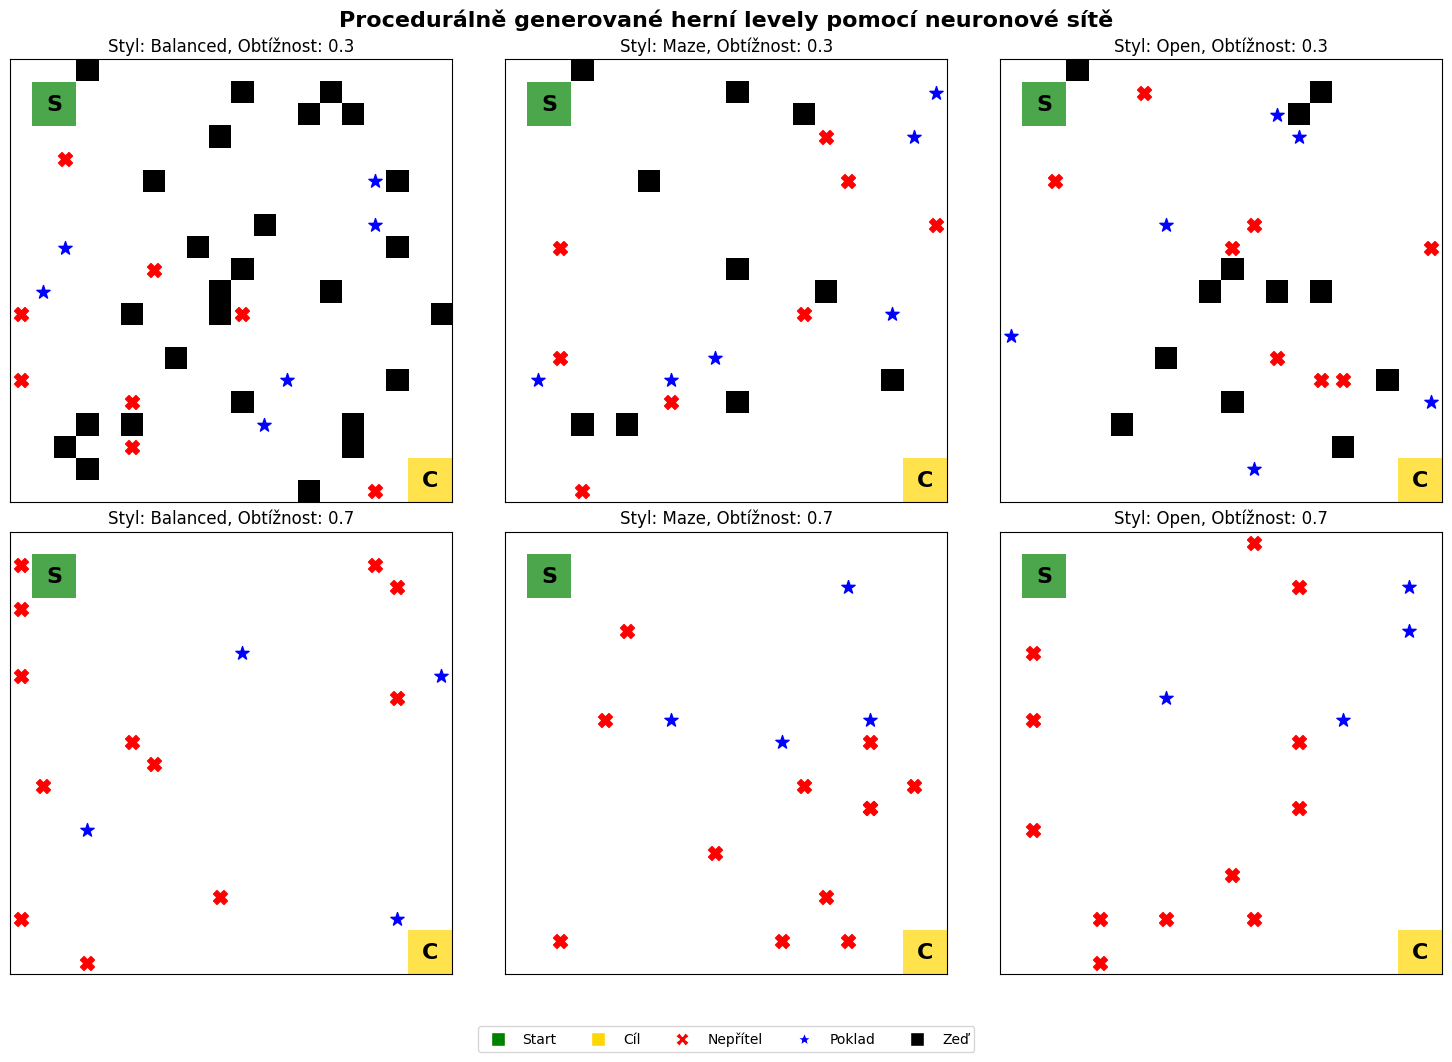


💡 Výhody procedurálního generování s AI:
  • Nekonečná variabilita levelů
  • Přizpůsobení obtížnosti hráči
  • Úspora času vývojářů
  • Personalizovaný herní zážitek


In [6]:
# Procedurální generování levelu pomocí neuronové sítě
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class LevelGeneratorNN(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Generator síť
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 20*20),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        level = self.generator(z)
        return level.view(-1, 20, 20)
    
    def generate_level(self, difficulty=0.5, style='balanced'):
        """Generování levelu podle parametrů"""
        # Vytvoření latentního vektoru podle stylu
        z = torch.randn(1, self.latent_dim)
        
        # Úprava podle stylu
        if style == 'maze':
            z[:, 0] = 2.0  # Více zdí
            z[:, 1] = -1.0  # Méně volného prostoru
        elif style == 'open':
            z[:, 0] = -2.0  # Méně zdí
            z[:, 1] = 2.0   # Více volného prostoru
        elif style == 'puzzle':
            z[:, 2] = 2.0   # Více interaktivních prvků
        
        # Úprava podle obtížnosti
        z[:, 3] = difficulty * 2 - 1  # -1 až 1
        
        with torch.no_grad():
            level = self.forward(z).squeeze().numpy()
        
        # Post-processing
        level = self.post_process(level, difficulty)
        
        return level
    
    def post_process(self, level, difficulty):
        """Vyčištění a vylepšení levelu"""
        # Prahování
        threshold = 0.3 + difficulty * 0.3
        level_discrete = (level > threshold).astype(int)
        
        # Přidání speciálních prvků
        # Start pozice (vždy vlevo nahoře)
        level_discrete[1:3, 1:3] = 0
        
        # Cíl (vždy vpravo dole)
        level_discrete[-3:-1, -3:-1] = 0
        
        # Zajištění cesty (jednoduchý algoritmus)
        self.ensure_path(level_discrete)
        
        # Přidání nepřátel podle obtížnosti
        num_enemies = int(5 + difficulty * 10)
        enemies = []
        for _ in range(num_enemies):
            while True:
                x, y = np.random.randint(0, 20, 2)
                if level_discrete[y, x] == 0 and (x, y) not in [(1, 1), (18, 18)]:
                    enemies.append((x, y))
                    break
        
        # Přidání pokladů
        num_treasures = int(3 + (1-difficulty) * 5)
        treasures = []
        for _ in range(num_treasures):
            while True:
                x, y = np.random.randint(0, 20, 2)
                if level_discrete[y, x] == 0 and (x, y) not in enemies + [(1, 1), (18, 18)]:
                    treasures.append((x, y))
                    break
        
        return level_discrete, enemies, treasures
    
    def ensure_path(self, level):
        """Zajištění, že existuje cesta od startu k cíli"""
        # Jednoduchý algoritmus - vytvoření přímé cesty
        x, y = 1, 1
        target_x, target_y = 18, 18
        
        while x != target_x or y != target_y:
            if x < target_x and np.random.random() > 0.3:
                x += 1
            elif y < target_y:
                y += 1
            
            level[y, x] = 0

# Vytvoření a trénování generátoru
print("🎮 PROCEDURÁLNÍ GENEROVÁNÍ LEVELŮ S AI\n")

generator = LevelGeneratorNN()

# Trénování generátoru (simulované pro demo)
print("🧠 Trénuji generátor levelů...")
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

for epoch in range(50):
    # Simulovaný trénink
    z = torch.randn(10, generator.latent_dim)
    levels = generator(z)
    
    # Simulovaná loss funkce - chceme rozumnou distribuci zdí
    wall_ratio = levels.mean()
    loss = (wall_ratio - 0.3)**2
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("✅ Generátor natrénován!\n")

# Generování různých levelů
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
styles = ['balanced', 'maze', 'open']
difficulties = [0.3, 0.7]

for i, difficulty in enumerate(difficulties):
    for j, style in enumerate(styles):
        ax = axes[i, j]
        
        # Generování levelu
        level, enemies, treasures = generator.generate_level(difficulty, style)
        
        # Vizualizace
        # Základní level
        ax.imshow(level, cmap='binary', interpolation='nearest')
        
        # Start a cíl
        ax.add_patch(plt.Rectangle((0.5, 0.5), 2, 2, facecolor='green', alpha=0.7))
        ax.text(1.5, 1.5, 'S', ha='center', va='center', fontsize=16, fontweight='bold')
        
        ax.add_patch(plt.Rectangle((17.5, 17.5), 2, 2, facecolor='gold', alpha=0.7))
        ax.text(18.5, 18.5, 'C', ha='center', va='center', fontsize=16, fontweight='bold')
        
        # Nepřátelé
        for ex, ey in enemies:
            ax.scatter(ex, ey, c='red', s=100, marker='X')
        
        # Poklady
        for tx, ty in treasures:
            ax.scatter(tx, ty, c='blue', s=100, marker='*')
        
        ax.set_title(f'Styl: {style.capitalize()}, Obtížnost: {difficulty}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, alpha=0.3)

plt.suptitle('Procedurálně generované herní levely pomocí neuronové sítě', fontsize=16, fontweight='bold')
plt.tight_layout()

# Legenda
legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Start'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gold', markersize=10, label='Cíl'),
    plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='red', markersize=10, label='Nepřítel'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=10, label='Poklad'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=10, label='Zeď')
]
fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=5)

plt.show()

print("\n💡 Výhody procedurálního generování s AI:")
print("  • Nekonečná variabilita levelů")
print("  • Přizpůsobení obtížnosti hráči")
print("  • Úspora času vývojářů")
print("  • Personalizovaný herní zážitek")

## 6. Cvičení a úkoly

### Úkol 1: Vytvořte vlastní herní AI

In [8]:
# Úkol: Vytvořte AI pro hru Kámen-Nůžky-Papír, která se učí z historie
class RockPaperScissorsAI:
    def __init__(self):
        self.history = []
        self.opponent_patterns = {}
        
    def predict_opponent_move(self):
        """
        TODO: Implementujte predikci dalšího tahu soupeře
        na základě historie tahů
        """
        pass
    
    def choose_move(self):
        """
        TODO: Vyberte nejlepší tah na základě predikce
        """
        pass
    
    def update_history(self, opponent_move, ai_move, result):
        """
        TODO: Aktualizujte historii a vzory
        """
        pass

# Implementujte a otestujte vaši AI

## 7. Shrnutí

### Co jsme se naučili:
- ✅ Historie a vývoj AI ve hrách
- ✅ Různé techniky herní AI (FSM, Minimax, Neural Networks)
- ✅ Implementace DQN pro učení her
- ✅ Procedurální generování obsahu
- ✅ Praktické použití AI v moderních hrách

### Klíčové poznatky:
1. **AI dělá hry zajímavější** - od jednoduchých duchů po komplexní NPCs
2. **Různé hry vyžadují různé AI** - není univerzální řešení
3. **Moderní AI se učí** - reinforcement learning revolucionalizuje hry
4. **Budoucnost je v personalizaci** - AI přizpůsobuje hru hráči

### Příště:
V další hodině začneme s mini projektem využívajícím AI!

## 8. Domácí úkol

1. **Vylepšete Snake AI**:
   - Přidejte více features do stavu
   - Experimentujte s architekturou sítě
   - Zkuste dosáhnout skóre 10+

2. **Naprogramujte Connect 4 s AI**:
   - Implementujte pravidla hry
   - Vytvořte Minimax AI s alpha-beta pruning
   - Přidejte různé úrovně obtížnosti

3. **Analyzujte oblíbenou hru**:
   - Vyberte hru, kterou hrajete
   - Popište, jaké AI techniky používá
   - Navrhněte vylepšení

4. **Kreativní projekt**:
   - Navrhněte vlastní jednoduchou hru
   - Implementujte základní AI protivníka
   - Použijte neuronovou síť nebo jiný algoritmus

---

**🏆 Výzva**: Vytvořte AI, která dokáže porazit vás ve vaší oblíbené hře!

### 8.4 AI ve hrách — stručně pro desetiletého

AI ve hrách znamená, že počítač "přemýšlí", jak vyhrát. U jednoduchých her (např. Tic‑Tac‑Toe / piškvorky 3×3) můžeme napsat pravidla, která zkoumají všechny možné tahy a vyberou nejlepší. Jeden z takových algoritmů se jmenuje minimax: zkusí každý tah, podívá se, jak by protihráč reagoval, a nakonec zvolí tah, který maximalizuje jeho šanci na výhru.

V tomto krátkém příkladu uvidíme velmi jednoduchou a čitelnou implementaci minimax pro Tic‑Tac‑Toe. Cílem je porozumět nápadu, ne optimalizovat výkon.

In [ ]:
# Simple Tic-Tac-Toe (3x3) with minimax
# Board is a list of 9 elements: 'X', 'O', or ' ' (empty)

def print_board(b):
    for i in range(3):
        print('|'.join(b[i*3:(i+1)*3]))
    print()


def winner(b):
    wins = [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]
    for (a,b1,c) in wins:
        if b[a] == b[b1] == b[c] and b[a] != ' ':
            return b[a]
    if ' ' not in b:
        return 'Tie'
    return None


def minimax(board, player):
    """Return (score, move_index). X is maximizing (+1), O is minimizing (-1)."""
    win = winner(board)
    if win == 'X':
        return (1, None)
    if win == 'O':
        return (-1, None)
    if win == 'Tie':
        return (0, None)

    if player == 'X':
        best = (-999, None)
        for i in range(9):
            if board[i] == ' ':
                board[i] = 'X'
                score, _ = minimax(board, 'O')
                board[i] = ' '
                if score > best[0]:
                    best = (score, i)
        return best
    else:
        best = (999, None)
        for i in range(9):
            if board[i] == ' ':
                board[i] = 'O'
                score, _ = minimax(board, 'X')
                board[i] = ' '
                if score < best[0]:
                    best = (score, i)
        return best

# Quick smoke test: X to move on empty board -> best move exists (any corner or center is fine)
board = [' ']*9
score, move = minimax(board, 'X')
print('Best score for X on empty board:', score, 'best move index:', move)
assert score == 0 or score == 1  # with perfect play Tic-Tac-Toe is tie, so 0 is expected, but allow 1 for move heuristics
# Make a forced win scenario for X
board = ['X','X',' ', 'O','O',' ', ' ',' ',' ']
score, move = minimax(board, 'X')
print('Forced win scenario: score,move =', score, move)
assert move is not None


Úkoly:

1) Zkuste spustit cell s minimaxem a prozkoumejte, jak se chová pro různé board konfigurace.
2) Vylepšete heuristiku tak, aby preferovala rohy a střed (zrychlí to rozhodování a zlepší estetiku tahu).
3) Bonus: přidejte alpha‑beta ořezávání (alpha‑beta pruning) a porovnejte počet provedených rekurzí proti čistému minimaxu.